Batch Normalization

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    if not torch.is_grad_enabled(): # Not grad
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else: # Grad
        assert len(X.shape) in (2, 4) # 2 is MLP, 4 is CNN
        if len(X.shape) == 2: # Linear layer
            mean = X.mean(dim=0) # Row vector (Horizontal)
            var = ((X - mean)**2).mean(dim=0) # Row vector (Horizontal)
        else: # Convolutional layer
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean)**2).mean(dim=(0, 2, 3), keepdim=True)
        X_hat = (X - mean) / torch.sqrt(var + eps) # Normalized input
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta # Combine formula, gamma and beta are learnable parameters
    return Y, moving_mean.data, moving_var.data

In [2]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2: # Linear layer
            shape = (1, num_features)
        else: # Convolutional layer
            shape = (1, num_features, 1, 1)
        # Initialization
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        if self.moving_mean.device != X.device: # Make sure the device can be matched
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moving_var, eps=1e-5, momentum=0.9
        )
        return Y

In [3]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), 
    BatchNorm(6, num_dims=4),
    nn.Sigmoid(), 
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), 
    BatchNorm(16, num_dims=4),
    nn.Sigmoid(), 
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(), 
    nn.Linear(16 * 4 * 4, 120),
    BatchNorm(120, num_dims=2), 
    nn.Sigmoid(),
    nn.Linear(120, 84), 
    BatchNorm(84, num_dims=2),
    nn.Sigmoid(), 
    nn.Linear(84, 10)
)

loss 0.248, train acc 0.909, test acc 0.845
27515.9 examples/sec on cuda:0


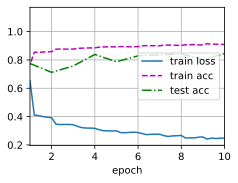

In [4]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [5]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([1.4099, 1.2050, 2.3666, 1.4878, 1.0707, 2.5551], device='cuda:0',
        grad_fn=<ViewBackward0>),
 tensor([-0.2643, -1.2331,  1.8669, -1.9057, -0.7159,  0.2291], device='cuda:0',
        grad_fn=<ViewBackward0>))

In [6]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), 
    nn.BatchNorm2d(6),
    nn.Sigmoid(), 
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), 
    nn.BatchNorm2d(16),
    nn.Sigmoid(), 
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(), 
    nn.Linear(256, 120), 
    nn.BatchNorm1d(120),
    nn.Sigmoid(), 
    nn.Linear(120, 84), 
    nn.BatchNorm1d(84),
    nn.Sigmoid(), 
    nn.Linear(84, 10)
)

loss 0.248, train acc 0.909, test acc 0.849
48283.8 examples/sec on cuda:0


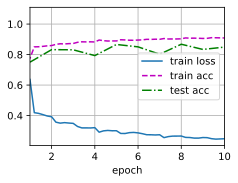

In [7]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())